In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from helper import *
from networks import *
from data_handler import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'
BATCH_SIZE = 1 #Inconsistent image size, thus batch sizeis one for adaptive input

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = 16 # Set to your device

torch.set_float32_matmul_precision('medium')

cuda:0


In [2]:
# Generate STD and Mean from train data for normalisation
# train_ds = torchvision.datasets.ImageFolder("./data/imgs/train/",transform=transforms.ToTensor())
# means, stds = norm_stats_2D(train_ds)

#Output from above lines
means = [0.6598784563532518, 0.5282382175840284, 0.26685126321971003]
stds = [0.13364640444095852, 0.1672512971251833, 0.30953234263722934]

print(means)
print(stds)

[0.6598784563532518, 0.5282382175840284, 0.26685126321971003]
[0.13364640444095852, 0.1672512971251833, 0.30953234263722934]


In [3]:
# Create transform with normalisation
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [4]:
#Sets and Loaders
train_set = torchvision.datasets.ImageFolder("./data/imgs/train/",transform=data_transforms)
val_set = torchvision.datasets.ImageFolder("./data/imgs/val/",transform=data_transforms)
test_set = torchvision.datasets.ImageFolder("./data/imgs/test/",transform=data_transforms)

# Create Dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, persistent_workers=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [5]:
# Initialize the CNN model
trainer = make_trainer("v2_2",30,earlyStoppingPatience=5,refreshRate=100)
model_cnn = ImageCNN(train_loader,valid_loader,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
# Fit/Save/Load - comment relevant parts
# trainer_task.fit(model_cnn)
# torch.save(model_cnn,"./models/v2_2/model_1.pt")
# model_cnn = torch.load("./models/v2_2/model_1.pt")
model_cnn = ImageCNN.load_from_checkpoint("./checkpoints_section/v2_2/epoch=7-step=315224.ckpt",trainloader=train_loader, valloader=valid_loader, testloader = test_loader)

In [8]:
model_cnn.eval()
trainer.test(model_cnn,test_loader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │            0.0            │
│         test_acc          │    0.8744984269142151     │
│         test_loss         │    0.5790451169013977     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5790451169013977,
  'test_acc': 0.8744984269142151,
  'epoch': 0.0}]

18


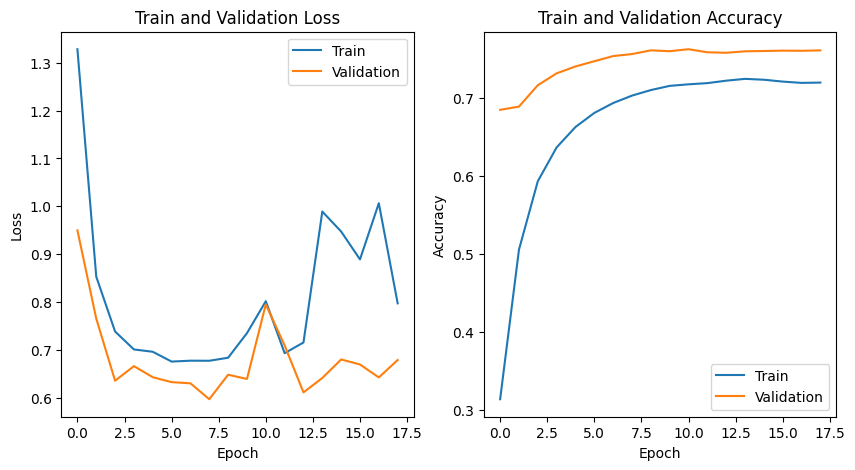

In [9]:
METRICS_PATH = "./logs_task/v2_2/lightning_logs/version_1"
plot_logs(METRICS_PATH)

In [7]:
#Ranking statistics
test_dfs = pd.read_pickle("./data/test_data.pickle").reset_index()
grad_stats_list = saliency_ImageCNN(test_set,test_dfs,model_cnn)
np.save("./results/v4/rank_stats.npy",np.array(grad_stats_list))

[ 6682  4220 11039  5929 11976  9617  8360  3482   984  8549 12616  9211
 11859 11477  5249 13083 12826  9332  4285  4621  8491  6206 10655  1418
  7031 13346  1458  9228  5790  3553  3837  8427 11122  6045  4609  9633
 11776  2820  5195  6139 12212  9978 12655  4075  6160  3647 10963 13479
 12574 10372  1421 13349 12999  2816  2443 11274 13051  1368   135  2368
  6626  7718  9521 10987  1135   624 13303  5250  1496  9411  1024  4627
 11593  2876  1790   568  5957  3167  9142  7664 10738  9975 11013  8738
  3580  4954 10899  5081  8457  8004  8223  5514 10778  6190 11009  6647
 11933  8890  7156  3803]


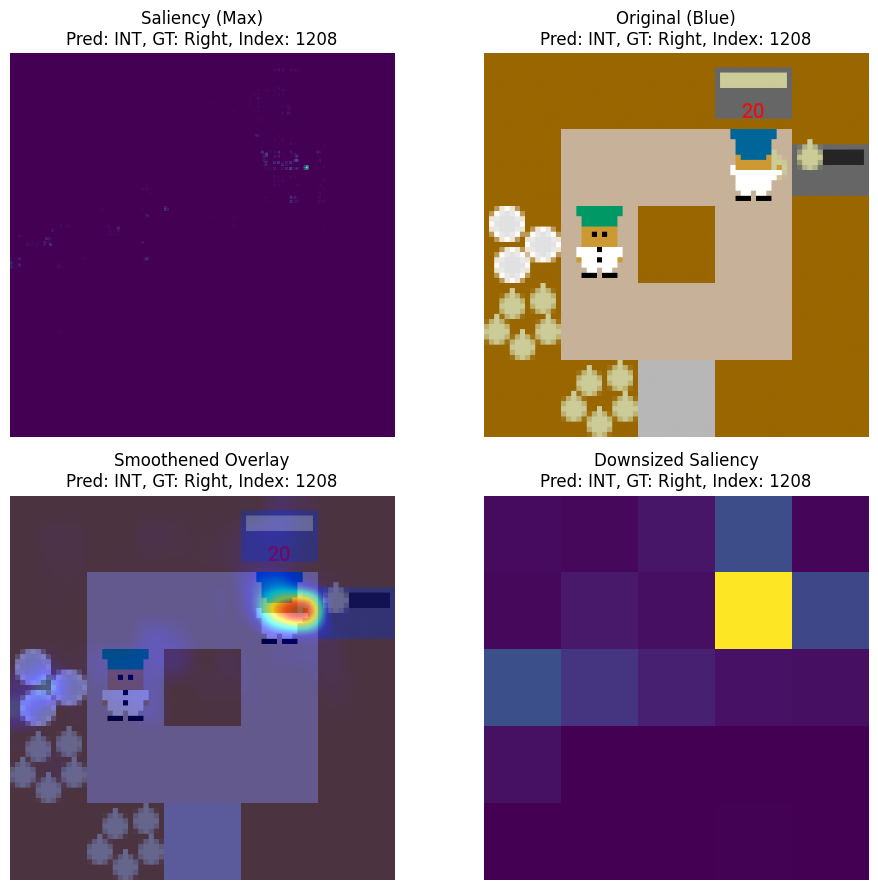

In [8]:
#Save Examples
np.random.seed(321)
results_indices = np.random.randint(0,len(test_dfs),size=100)
print(results_indices)
saliency_ImageCNN(test_set, test_dfs, model_cnn, index_list=results_indices,save_plot=True);